# South Africa Heart Diseases Data
A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of Coranary Heart Disease (CHD). Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

| Variable name     | Description              |
|:---------|:-------------------------|
| sbp	  |	systolic blood **pressure** |
| tobacco	|	cumulative **tobacco** (kg) |
| ldl |		low densiity lipoprotein **cholesterol** |
| adiposity |                                     |
| famhist	 |	**family** history of heart disease (Present=1, Absent=0) |
| typea	|	type-A **behavior** |
| obesity |            |
| alcohol	|	current **alcohol** consumption |
| age		| **age** at onset |
| chd		| **response**: coronary heart disease  (Present=1, Absent=0) |

In [1]:
import pandas as pd
import numpy as np

#load data set
heart = pd.read_csv('SAheart.csv', sep=',', header=0)
heart.head() #data overview: variable names and first values

row.names  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
0          1  160    12.00  5.73      23.11        1     49    25.30    97.20   
1          2  144     0.01  4.41      28.61        0     55    28.87     2.06   
2          3  118     0.08  3.48      32.28        1     52    29.14     3.81   
3          4  170     7.50  6.41      38.03        1     51    31.99    24.26   
4          5  134    13.60  3.50      27.78        1     60    25.99    57.34   

   age  chd  
0   52    1  
1   63    1  
2   46    0  
3   58    1  
4   49    1

In [2]:
y = np.asarray( heart.iloc[:,10], 'float' )
X = np.asarray( heart.iloc[:,1:10], 'float' )
names = list(heart.columns[1:10])

# Data matrix X is (n,p) where p is the number of variable and n the number of sample
(n,p)=X.shape
ncases= int(np.sum(y)) # number of cases
print('There is {} samples: {} cases and {:d} control'.format(n,ncases,n-ncases))

There is 462 samples: 160 cases and 302 control


## Compute lasso path

In [3]:
#compute lasso path
from sklearn import linear_model
from time import time
from sklearn.svm import l1_min_c
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Standardize the data
sc = StandardScaler()
Xs= sc.fit_transform(X)

cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 4, 30)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      multi_class='multinomial',
                                      warm_start=True)
coefs_ = []
beta_l1norm = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(Xs, y)
    beta_l1norm.append( np.sum(np.abs(clf.coef_.ravel()))) 
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

betas = np.array(coefs_)

Computing regularization path ...
This took 4.671s


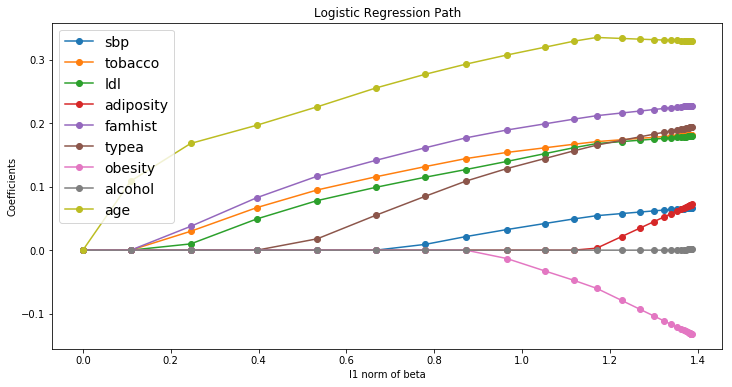

In [4]:
# Display lasso path Vs l1 norm of the coeff vector
plt.figure(figsize=(12,6))
#plt.plot(np.log10(cs), coefs_, marker='o')
plt.plot(beta_l1norm, betas, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('l1 norm of beta')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.legend(names, fontsize=14)
plt.show()

## Cross validation
We estimate the optimal regularization parameter

In [5]:
# K fold cross validation  (K=10)
cs = l1_min_c(Xs, y, loss='log') * np.logspace(0, 2, 50)
model = linear_model.LogisticRegressionCV(Cs=cs, cv=5, penalty='l1', solver='saga', 
                                  multi_class='multinomial', random_state=1,tol=1e-6).fit(Xs,y)
cv_l1norm = np.sum(np.abs(model.coef_))
df = pd.DataFrame(data=model.coef_, columns=names)

# Display results
print('l1 norm of the CV coeff vector = {} (penalty C={})\n'.format(cv_l1norm, model.C_[0]))
print('cross validated coeffs =\n{}'.format(df))

l1 norm of the CV coeff vector = 0.6708959589770789 (penalty C=0.06027487268684572)

cross validated coeffs =
   sbp   tobacco       ldl  adiposity   famhist    typea  obesity  alcohol  \
0  0.0  0.116258  0.099681        0.0  0.142326  0.05608      0.0      0.0   

        age  
0  0.256551  
